Here the goal is to make a generative model that would take input a foot pair, a sleeper pair and genrate an output of foot sleeper combination.

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras import backend as k
from tensorflow.keras import regularizers

2021-10-06 12:08:44.318511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 12:08:44.318595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
f = open('pairs.txt', 'r')
text = f.read()
code_for_list = 'pairs = {}'.format(text)
exec(code_for_list)
print(pairs[0])
print(len(pairs))

['f_0_0.jpg', 's_0_0.jpg', 'sf_0_0_0.jpg']
640


In [3]:
# Randomizing the pairs
# Also setting a random seed for always the same random effect.
random.seed(4)
pairs_shuffled = random.sample(pairs, k=len(pairs))

In [4]:
# Now importing all the files
X_1 = []
X_2 = []
Y = []

source_path = 'data/training/all_data_named_resized/'
# source_path = 'data/training/all_data_resized_2/'

for ele in pairs_shuffled:
    foot = ele[0]
    sleeper = ele[1]
    foot_sleeper = ele[2]
    
    foot_img = cv2.imread(source_path + foot)
    foot_img = cv2.cvtColor(foot_img, cv2.COLOR_BGR2RGB)
    X_1.append(foot_img)

    sleeper_img = cv2.imread(source_path + sleeper)
    sleeper_img = cv2.cvtColor(sleeper_img, cv2.COLOR_BGR2RGB)
    X_2.append(sleeper_img)

    foot_sleeper_img = cv2.imread(source_path + foot_sleeper)
    foot_sleeper_img = cv2.cvtColor(foot_sleeper_img, cv2.COLOR_BGR2RGB)
    Y.append(foot_sleeper_img)

X_1 = np.array(X_1)
X_2 = np.array(X_2)
Y = np.array(Y)

print(X_1.shape)
print(X_2.shape)
print(Y.shape)


(640, 128, 64, 3)
(640, 128, 64, 3)
(640, 128, 64, 3)


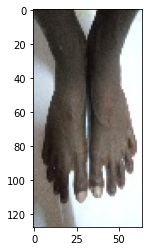

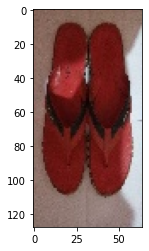

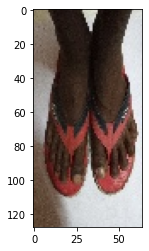

In [5]:
# Vizualiaing the data pairs
# Checking all the pairs are correct or not
index = 490

foot_img = X_1[index]
sleeper_img = X_2[index]
foot_sleeper_img  = Y[index]

plt.imshow(foot_img)
plt.show()

plt.imshow(sleeper_img)
plt.show()

plt.imshow(foot_sleeper_img)
plt.show()

# The pairs are correct.

In [6]:
# Making the Train Dev Split
# for this Problem we are taking just 10% of our sample for Dev set.
X_1_train = X_1[:640-64]
X_2_train = X_2[:640-64]
Y_train = Y[:640-64]

X_1_dev = X_1[640-64:]
X_2_dev = X_2[640-64:]
Y_dev = Y[640-64:]

print(X_1_train.shape, X_2_train.shape, Y_train.shape)
print(X_1_dev.shape, X_2_dev.shape, Y_dev.shape)


(576, 128, 64, 3) (576, 128, 64, 3) (576, 128, 64, 3)
(64, 128, 64, 3) (64, 128, 64, 3) (64, 128, 64, 3)


## Building the Generative Neural Network

In [7]:
# Defining a Custom Activation Function
def custom_activation(x):
    return (k.sigmoid(x) * 255)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 24576)        0           input_16[0][0]                   
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 24576)        0           input_17[0][0]                   
____________________________________________________________________________________________

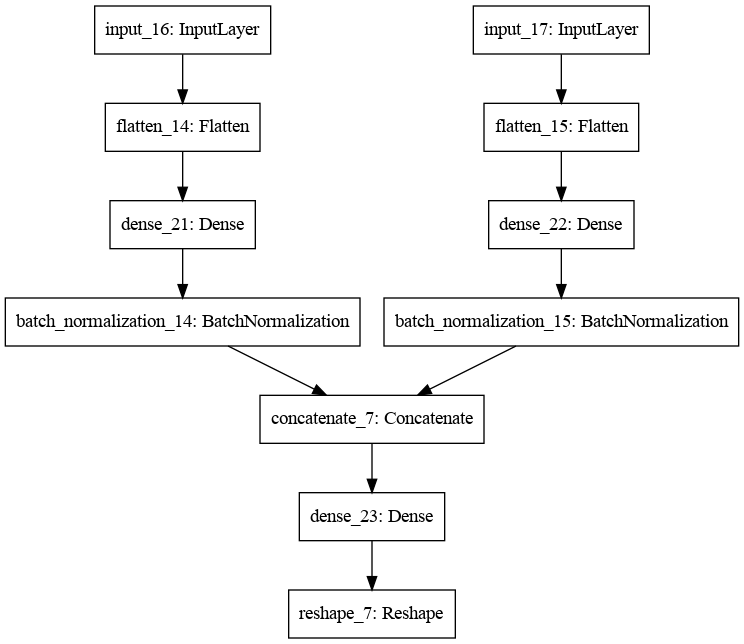

In [86]:
# Building CNN for feet input.
input_layer_1 = tf.keras.layers.Input(shape=(128, 64, 3))
x = tf.keras.layers.Flatten()(input_layer_1)
x = tf.keras.layers.Dense(8, activation=tf.nn.relu)(x)
feet_encoding = tf.keras.layers.BatchNormalization()(x)

# -------------------------------------------------------------------------------------------
# Building CNN for sleeper input.
input_layer_2 = tf.keras.layers.Input(shape=(128, 64, 3))
x = tf.keras.layers.Flatten()(input_layer_2)
x = tf.keras.layers.Dense(8, activation=tf.nn.relu)(x)
sleeper_encoding = tf.keras.layers.BatchNormalization()(x)

# -------------------------------------------------------------------------------------------
z = tf.keras.layers.concatenate([feet_encoding, sleeper_encoding])

x = tf.keras.layers.Dense(128*64*3, activation=custom_activation, kernel_regularizer=regularizers.l2(1))(z)
output_layer = tf.keras.layers.Reshape((128, 64, 3))(x)

model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)
model.summary()
tf.keras.utils.plot_model(model)

In [228]:
# Importing the Model.
model = tf.keras.models.load_model('models/model_1/')
# model_eval.summary()

In [290]:
# Definging the 'Cost Function', 'Optimizer' and 'Evaluation Metrics' for the Model.
model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy']
)

In [294]:
model.fit([X_1_train, X_2_train], Y_train, batch_size=len(X_1_train), epochs=8, verbose=2)

Epoch 1/8
1/1 - 0s - loss: 1252.9540 - accuracy: 0.8638
Epoch 2/8
1/1 - 0s - loss: 1253.1125 - accuracy: 0.8635
Epoch 3/8
1/1 - 0s - loss: 1253.0653 - accuracy: 0.8638
Epoch 4/8
1/1 - 0s - loss: 1252.8757 - accuracy: 0.8641
Epoch 5/8
1/1 - 0s - loss: 1252.7520 - accuracy: 0.8642
Epoch 6/8
1/1 - 0s - loss: 1252.7869 - accuracy: 0.8641
Epoch 7/8
1/1 - 0s - loss: 1252.8788 - accuracy: 0.8638
Epoch 8/8
1/1 - 0s - loss: 1252.8868 - accuracy: 0.8640


In [295]:
# Evaluating the Model
print(model.evaluate([X_1_dev, X_2_dev], Y_dev, batch_size=len(X_1_train), verbose=2))

1/1 - 0s - loss: 1252.8428 - accuracy: 0.8687
[1252.8427734375, 0.8686714172363281]


In [265]:
# Saving the Model. Once we get a good model then only we save the model using the following codes. 
# model.save('models/model_1/')

INFO:tensorflow:Assets written to: models/model_1/assets


## Evaluating the Model

In [2]:
# Importing the Model.
model_eval = tf.keras.models.load_model('models/model_1/')

model_eval.summary()

2021-10-05 21:16:39.157187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-05 21:16:39.157235: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-05 21:16:39.157260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sainilayam-NS14A2): /proc/driver/nvidia/version does not exist
2021-10-05 21:16:39.157546: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
flatten_34 (Flatten)            (None, 24576)        0           input_35[0][0]                   
__________________________________________________________________________________________________
flatten_35 (Flatten)            (None, 24576)        0           input_36[0][0]                   
___________________________________________________________________________________________

(128, 64, 3)


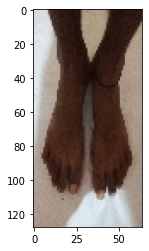

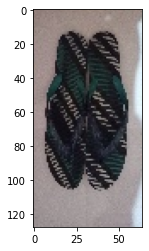

Expected Image: 


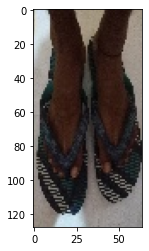

Our Output Image: 


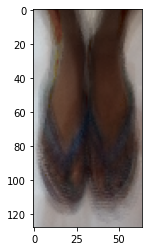

In [298]:
# Intepretating our Models Predictions
index = 1

input_feet = X_1_dev[index]
input_feet = np.array([input_feet])
# print(input_feet.shape)

input_sleeper = X_2_dev[index]
input_sleeper = np.array([input_sleeper])
# print(input_sleeper.shape)

output_feet_sleeper = Y_dev[index]

prediction_input = [input_feet, input_sleeper]

# Getting the predicted Image.
output_img = model.predict(prediction_input)[0]
print(output_img.shape)
# print(output_img)

output_img_bgr = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_img.jpg', output_img_bgr)

plt.imshow(input_feet[0])
plt.show()

plt.imshow(input_sleeper[0])
plt.show()

print('Expected Image: ')
plt.imshow(output_feet_sleeper)
plt.show()

# Before showing the image using Matplotlib, we need to convert all of our values to integers.
output_img_int = output_img.astype(int)
print('Our Output Image: ')
plt.imshow(output_img_int)
plt.show()

In [ ]:
# Applying some post processing steps. We are going to sharpen the Image a little bit.

